In [1]:
import os
from datetime import datetime
import tensorboard
from keras.callbacks import TensorBoard
from keras.models import Model
import numpy as np
from Experiments import network as net
from Experiments import data_prep as dp
import argparse
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

Using TensorFlow backend.


In [2]:
np.random.seed(30091992)

In [3]:
params={}

### Experiment Parameters ###

params['state_features'] = 1

### Hyper Parameters ###
params['hp_num_neighbors'] = 8

params['hp_num_complex_pairs'] = 1
params['hp_num_real'] = 4

params['hp_beta_units'] = 8

enc_dec_size = 8
params['hp_phi_enc_units'] = enc_dec_size
params['hp_psi_enc_units'] = enc_dec_size
params['hp_psi_dec_units'] = enc_dec_size

params['hp_delta_units'] = 8

l1_reg = 1.3371e-13
params['hp_l1_reg'] = l1_reg
params['hp_l2_reg'] = l1_reg*1e-2

In [4]:
ae, pipeline = net.pipeline(params)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
pipeline.load_weights("Experiments/Realizations/20230803-112518_pipeline.h5")

In [6]:
x = np.array([1,1,0,0,
              1,1,1,1,
              1,1,1,1,
              0,0,0,0])
x_neigh = np.array([[0,0,0,0,0,0,0,0],
                    [0,1,0,0,0,0,0,0],
                    [0,0,0,0,0,1,0,0],
                    [0,0,0,0,0,0,0,1],
                    [0,1,1,0,1,0,0,1],
                    [1,1,1,1,1,1,0,1],
                    [1,0,0,0,1,1,1,0],
                    [1,1,1,1,1,1,1,1],
                    [1,1,1,0,0,0,0,0],
                    [0,0,1,0,1,0,1,0],
                    [1,0,0,0,0,0,0,1],
                    [0,1,0,0,1,0,0,0],
                    [1,1,1,0,0,0,0,0],
                    [0,0,0,0,0,1,1,1],
                    [0,1,0,0,1,0,1,0],
                    [0,0,1,1,0,1,0,0]])
gt_fs = np.array([0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1])

In [7]:
pipeline.predict([x,x_neigh])

array([[9.7795081e-01],
       [9.7789550e-01],
       [2.9802322e-07],
       [2.9802322e-07],
       [9.7796518e-01],
       [9.7810084e-01],
       [9.7796679e-01],
       [9.7815406e-01],
       [5.0067902e-06],
       [4.9769878e-06],
       [4.9769878e-06],
       [4.9769878e-06],
       [9.9999833e-01],
       [9.9999833e-01],
       [9.9999827e-01],
       [9.9999833e-01]], dtype=float32)

In [8]:
spin = np.where(pipeline.predict([x,x_neigh]) > 0.5 ,1,0)

In [9]:
spin

array([[1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]])

In [10]:
new_x = np.logical_xor(x,np.transpose((spin))).astype(int)
new_x== gt_fs

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]])

In [11]:
num_samples = 100000
x_samples = np.random.choice([0,1], (num_samples,1))
x_neigh_samples = np.random.choice([0,1], (num_samples,8))

neigh_settings = []
for i in range(num_samples):
    if x_samples[i,0] == 0:
        if np.count_nonzero(x_neigh_samples[i]) == 3:
            neigh_settings.append(10)
        else:
            neigh_settings.append(2)
    else:
        if np.count_nonzero(x_neigh_samples[i]) < 2:
            neigh_settings.append(3)
        elif np.count_nonzero(x_neigh_samples[i]) > 3:
            neigh_settings.append(8)
        else:
            neigh_settings.append(9)

spin_samples = np.where(pipeline.predict([x_samples,x_neigh_samples]) > 0.5 ,1,0)
    
myencoding = Model(inputs=pipeline.input, outputs=pipeline.layers[2].get_output_at(-1))
encoded_info = myencoding.predict([x_samples,x_neigh_samples])

mypostkoopmanencoding = Model(inputs=pipeline.input, outputs=pipeline.layers[3].get_output_at(-1))
mypostkoopmanencoded_info = mypostkoopmanencoding.predict([x_samples,x_neigh_samples])

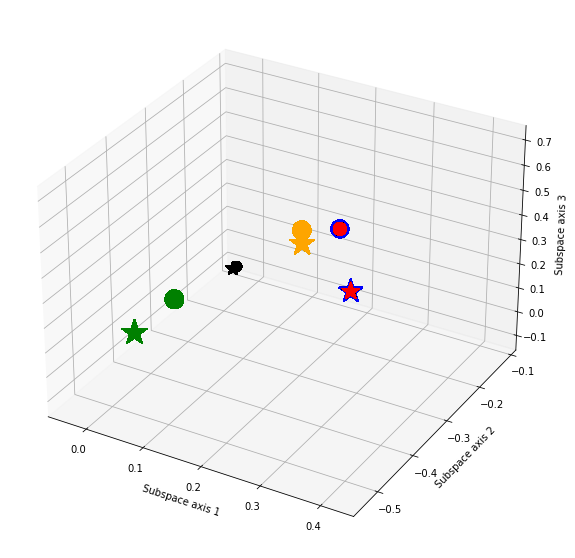

In [12]:
# use colormap
colormap = np.array(['black','black','black','red','black','black','black','black','blue','orange','green']) # For Red=Death by Underpop, Blue=Death by Overpop, Orange=Constant, Green=Reproduction, Black = Being Dead
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(encoded_info[:,0],encoded_info[:,1],encoded_info[:,3], c=colormap[neigh_settings], s=np.log2(np.array(neigh_settings))*100)
ax.scatter(mypostkoopmanencoded_info[:,0],mypostkoopmanencoded_info[:,1],mypostkoopmanencoded_info[:,3], c=colormap[neigh_settings], s=np.log2(np.array(neigh_settings))*200, marker="*")
ax.set_xlabel('Subspace axis 1')
ax.set_ylabel('Subspace axis 2')
ax.set_zlabel('Subspace axis 3')
plt.savefig('gol_koopman_invariant_subspace_dynamics.png')

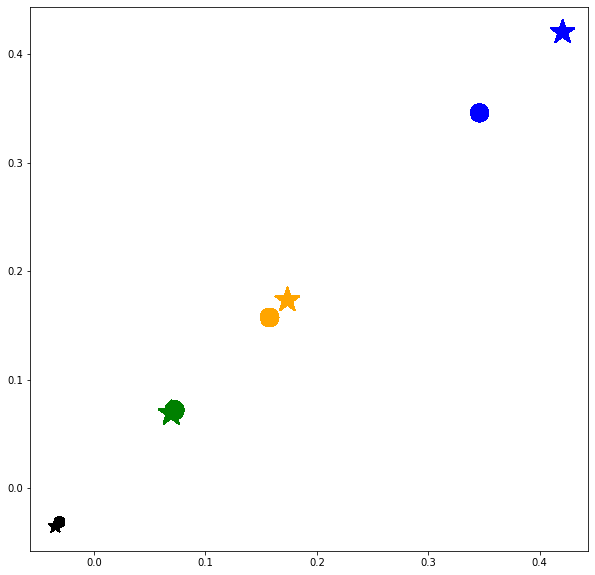

In [169]:
# use colormap
colormap = np.array(['black','black','black','red','black','black','black','black','blue','orange','green']) # For Spin/Not-Spin Red=Death by Underpop, Blue=Death by Overpop, Orange=Constant, Green=Reproduction, Black = Being Dead
fig = plt.figure(figsize=(10,10))
plt.scatter(encoded_info[:,0],encoded_info[:,0], c=colormap[neigh_settings], s=np.log2(np.array(neigh_settings))*100)
plt.scatter(mypostkoopmanencoded_info[:,0],mypostkoopmanencoded_info[:,0], c=colormap[neigh_settings], s=np.log2(np.array(neigh_settings))*200, marker="*")

In [ ]:
def rule_gol(c,neighbours):
    if c == 0:
        if np.count_nonzero(neighbours) == 3:
            return 1
        else:
            return 0
    else:
        if np.count_nonzero(neighbours) < 2:
            return 0
        elif np.count_nonzero(neighbours) > 3:
            return 0
        else:
            return 1

In [ ]:
def CA_run_step(old_grid_pred,old_grid_gt,size):
    new_grid_pred = np.zeros((size,size))
    new_grid_gt = np.zeros((size,size))
    for j in range(1,size-1):
        for k in range(1,size-1):
                x_pred = old_grid_pred[j,k]
                x_neigh_pred = [old_grid_pred[j-1,k],old_grid_pred[j-1,k-1],old_grid_pred[j-1,k+1],old_grid_pred[j,k-1],old_grid_pred[j,k+1],old_grid_pred[j+1,k-1],old_grid_pred[j+1,k],old_grid_pred[j+1,k+1]]
                # print(np.asarray(x_neigh_pred)[:,np.newaxis].shape)
                # print(pipeline.predict([np.asarray([x_pred])[:,np.newaxis],np.asarray([x_neigh_pred])]))
                spin = np.where(pipeline.predict([np.asarray([x_pred])[:,np.newaxis],np.asarray([x_neigh_pred])])[0][0] > 0.5 ,1,0)
                x_plus_pred = np.logical_xor(x_pred,spin).astype(int)
                new_grid_pred[j,k] = x_plus_pred

                x_gt = old_grid_gt[j,k]
                x_neigh_gt = [old_grid_gt[j-1,k],old_grid_gt[j-1,k-1],old_grid_gt[j-1,k+1],old_grid_gt[j,k-1],old_grid_gt[j,k+1],old_grid_gt[j+1,k-1],old_grid_gt[j+1,k],old_grid_gt[j+1,k+1]]
                x_plus_gt = rule_gol(x_gt,x_neigh_gt)
                new_grid_gt[j,k] = x_plus_gt
    return new_grid_pred, new_grid_gt

In [ ]:
l= []
# size = 11
# grid = np.zeros((size,size))

# # Beehive (Still Life)
# size = 11
# grid = np.zeros((size,size))
# name = 'beehive'
# midpoint = int((size+1)/2)
# grid[midpoint-1,  midpoint]   = 1
# grid[midpoint+1,  midpoint]   = 1
# grid[midpoint-1,  midpoint+1]   = 1
# grid[midpoint+1,  midpoint+1]   = 1
# grid[midpoint,  midpoint+2]   = 1
# grid[midpoint,  midpoint-1]   = 1


# # Beacon (Oscillator)
# size = 11
# grid = np.zeros((size,size))
# name = 'beacon'
# midpoint = int((size+1)/2)
# grid[midpoint-1,  midpoint-1]   = 1
# grid[midpoint-1,  midpoint-2]   = 1
# grid[midpoint-2,  midpoint-1]   = 1
# grid[midpoint-2,  midpoint-2]   = 1

# grid[midpoint,  midpoint]   = 1
# grid[midpoint+1,midpoint+1] = 1
# grid[midpoint,  midpoint+1] = 1
# grid[midpoint+1,midpoint]   = 1

# # Glider Initialize
# size = 31
# grid = np.zeros((size,size))
# name = 'glider'
# midpoint = int((size+1)/2)
# grid[midpoint,  midpoint-1] = 1
# grid[midpoint+1,midpoint] = 1
# grid[midpoint-1,midpoint+1] = 1
# grid[midpoint,  midpoint+1] = 1
# grid[midpoint+1,midpoint+1] = 1

# Colliding Gliders Initialize
size = 31
grid = np.zeros((size,size))
name = 'colliding_glider'
midpoint = int((size+1)/2)
delta = 6
offsetj = 3
grid[midpoint-delta,  1-offsetj+midpoint+delta]   = 1
grid[midpoint-delta-1,1-offsetj+midpoint+delta]   = 1
grid[midpoint-delta,  1-offsetj+midpoint+delta+1] = 1
grid[midpoint-delta,  1-offsetj+midpoint+delta+2] = 1
grid[midpoint-delta-2,1-offsetj+midpoint+delta+1] = 1

grid[midpoint+delta,  offsetj+midpoint-delta]   = 1
grid[midpoint+delta+1,offsetj+midpoint-delta]   = 1
grid[midpoint+delta,  offsetj+midpoint-delta-1] = 1
grid[midpoint+delta+2,offsetj+midpoint-delta] = 1
grid[midpoint+delta+1,offsetj+midpoint-delta-2]   = 1

tsteps = 50
tmp_pred = []
tmp_gt = []
tmp_pred.append(grid)
tmp_gt.append(grid)
for i in range(tsteps):
    grid_pred, grid_gt = CA_run_step(tmp_pred[-1],tmp_gt[-1],size)
    l.append(np.count_nonzero(grid_pred)/(size**2-np.count_nonzero(grid_pred)))
    tmp_pred.append(grid_pred)
    tmp_gt.append(grid_gt)

In [ ]:
fig, ax = plt.subplots()
# Minor ticks
ax.set_xticks(np.arange(-.5, size, 1), minor=True)
ax.set_yticks(np.arange(-.5, size, 1), minor=True)
ax.grid(which='minor',color='black', linestyle='-', linewidth=1)
gt_frames = [[ax.imshow(np.asarray(tmp_gt[0]),cmap=cm.Greys)]]+[[ax.imshow(np.asarray(tmp_gt[i]),cmap=cm.Greys,animated=True)] for i in range(1,len(tmp_gt))]
ani = animation.ArtistAnimation(fig, gt_frames, interval=100, blit=True,repeat_delay=1000)
ani.save('gol_'+name+'_gt.gif')
# pred_frames = [ax.imshow(np.asarray(tmp_pred[i]),animated=True) for i in range(len(tmp_pred))]

In [ ]:
fig, ax = plt.subplots()
# Minor ticks
ax.set_xticks(np.arange(-.5, size, 1), minor=True)
ax.set_yticks(np.arange(-.5, size, 1), minor=True)
ax.grid(which='minor',color='black', linestyle='-', linewidth=1)
pred_frames = [[ax.imshow(np.asarray(tmp_pred[0]),cmap=cm.Greys)]]+[[ax.imshow(np.asarray(tmp_pred[i]),cmap=cm.Greys,animated=True)] for i in range(1,len(tmp_pred))]
ani = animation.ArtistAnimation(fig, pred_frames, interval=100, blit=True,repeat_delay=1000)
ani.save('gol_'+name+'_pred.gif')

In [ ]:
timestep = 4
fig, ax = plt.subplots()
# Minor ticks
ax.set_xticks(np.arange(-.5, size, 1), minor=True)
ax.set_yticks(np.arange(-.5, size, 1), minor=True)
ax.grid(which='minor',color='black', linestyle='-', linewidth=1)
ax.imshow(np.asarray(tmp_pred[timestep]),cmap=cm.Greys)
plt.savefig('gol_'+name+'_tstep'+str(timestep)+'_pred.png')

fig, ax = plt.subplots()
# Minor ticks
ax.set_xticks(np.arange(-.5, size, 1), minor=True)
ax.set_yticks(np.arange(-.5, size, 1), minor=True)
ax.grid(which='minor',color='black', linestyle='-', linewidth=1)
ax.imshow(np.asarray(tmp_gt[timestep]),cmap=cm.Greys)
plt.savefig('gol_'+name+'_tstep'+str(timestep)+'_gt.png')

In [ ]:
plt.plot(l)